In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import data

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

class Cluster:
    def __init__(self, label, columns):
        self.label = label
        self.columns = columns
        
        X = data.all_food[columns.keys()]
        self.X = X.dropna()
        self.na_count = len(X) - len(self.X)

        self.k = self.elbow()

        self.clf = KMeans(n_clusters=self.k)
        self.clf.fit(self.X)

    def elbow(self, ks=range(2,10)):
        clfs = [KMeans(n_clusters=k).fit(self.X) for k in ks]
        inertias = [clf.inertia_ for clf in clfs]
        
        slopes = [inertias[k - min(ks)] - inertias[k + 1 - min(ks)] for k in range(min(ks), max(ks) - 1)]

        fractions =  [slopes[i + 1] / slopes[i] for i in range(0, len(slopes) - 1)]

        optimal_k = np.argmin(fractions) + min(ks) + 1

        # Plot it.
        plt.plot(ks, inertias, 'o-')

        # Highlight optimal point.
        radius = 15
        point = (optimal_k, inertias[optimal_k - min(ks)])
        plt.plot(point[0], point[1], 'o', ms=radius * 2, mec='g', mfc='none', mew=2)
        plt.annotate('Optimal K={}'.format(optimal_k), xy=point, xytext=(40, 60),
            textcoords='offset points',
            color='darkgreen',
            size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.3,head_width=1,head_length=0.8',
                facecolor='g',
                shrinkA=radius ,
                shrinkB=radius * 1.3,
                edgecolor='g',
            ),
        )

        # Title and labels.
        plt.title("Optimal Number of Clusters for {}".format(self.label))
        plt.ylabel("Sum of Squared Error")
        plt.xlabel("Number of Clusters (K)")

        # Show it.
        plt.show()

        return optimal_k

    def choose_k(self, k):
        pass

    @property
    def clusters(self):
        return pd.DataFrame(self.clf.cluster_centers_, columns=self.columns.values())

    @property
    def labels(self):
        return pd.Series(self.clf.labels_)
    
    @property
    def label_counts(self):
        return self.labels.value_counts()

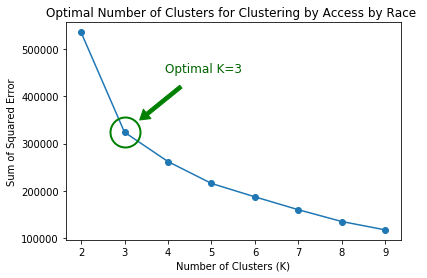

In [45]:
race = Cluster("Clustering by Access by Race ", {
    "PCT_LACCESS_WHITE15": "White, low access to store (%), 2015",
    "PCT_LACCESS_BLACK15": "Black, low access to store (%), 2015",
    "PCT_LACCESS_HISP15": "Hispanic ethnicity, low access to store (%), 2015",
    "PCT_LACCESS_NHASIAN15": "Asian, low access to store (%), 2015",
    "PCT_LACCESS_NHNA15": "American Indian or Alaska Native, low access to store (%), 2015",
    "PCT_LACCESS_NHPI15": "Hawaiian or Pacific Islander, low access to store (%), 2015",
})

In [46]:
race.clusters

,"White, low access to store (%), 2015","Black, low access to store (%), 2015","Hispanic ethnicity, low access to store (%), 2015","Asian, low access to store (%), 2015","American Indian or Alaska Native, low access to store (%), 2015","Hawaiian or Pacific Islander, low access to store (%), 2015"
0,27.740474,1.683210,3.043359,0.346872,1.123527,0.025588
1,9.879033,2.065146,0.928816,0.194347,0.543490,0.014600
2,85.447774,0.710596,10.234527,0.300431,1.157011,0.037614


In [20]:
race.label_counts

2    1331
0    1216
3     430
1     119
4      25
dtype: int64

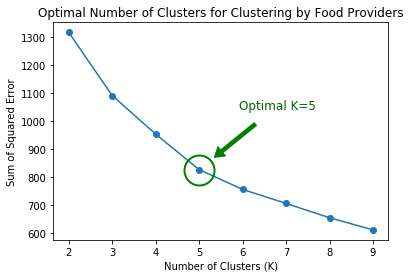

In [47]:
choice = Cluster("Clustering by Food Providers", {
    "GROCPTH14": "Grocery stores/1,000 pop, 2014",
    "SUPERCPTH14": "Supercenters & club stores/1,000 pop, 2014",
    "CONVSPTH14": "Convenience stores/1,000 pop, 2014",
    "SPECSPTH14": "Specialized food stores/1,000 pop, 2014",
    "FFRPTH14": "Fast-food restaurants/1,000 pop, 2014",
    "FSRPTH14": "Full-service restaurants/1,000 pop, 2014",
    "FMRKTPTH16": "Farmers' markets/1,000 pop, 2016",
})

In [10]:
choice.label_counts

4    1524
0    1084
1     451
3      77
2       4
dtype: int64